In [1]:
import sys  
sys.path.insert(0, '../py')
from graviti import *

from numpy.linalg import norm
import numpy as np
import os
import os.path
from os import path
import sys
import glob
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.use('Agg')
import plotly.graph_objects as go
from plotly.graph_objs import *
import plotly.express as px
import hdbscan
import pandas as pd
import umap
import networkx as nx
from scipy import sparse, linalg
import pickle
from sklearn.preprocessing import normalize, scale
from scipy.sparse import find
from numpy.linalg import norm
import timeit
import multiprocessing
from joblib import Parallel, delayed
from datetime import datetime
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KDTree
from sklearn.neighbors import NearestNeighbors

In [4]:
size = 100000 # number of nuclei, use 0 value for full set
nn = 10 # set the number of nearest neighbor in the umap-graph. Will be used in CovD as well

TCGA-49-4512-01Z-00-DX6
Loading the data
Downsampling the data
Creating the UMAP graph
Generation of the nn of the sampled nodes


  0%|          | 0/100000 [00:00<?, ?it/s]

Generating the descriptor


  0%|          | 0/100000 [00:00<?, ?it/s]

Generating the diversity index


100%|██████████| 100000/100000 [01:07<00:00, 1473.33it/s]


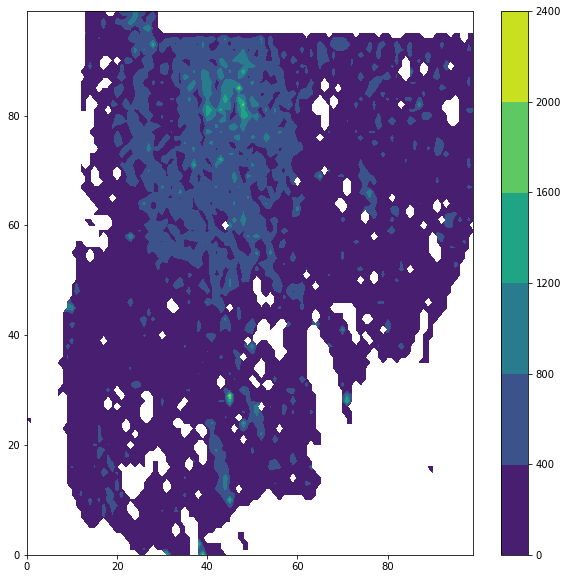

In [6]:
#for file in glob.glob('/media/garner1/hdd2/tcga.detection/*.gz'):
for file in glob.glob('../data/tcga.detection/*.gz')[:1]:
    
    sample = os.path.basename(file).split(sep='.')[0]; print(sample)
    
    print('Loading the data')
    df = pd.read_csv(file,sep='\t').head(n=1000000)
#    df = pd.read_csv(file,sep='\t')

    features = df.columns[7:]
    centroids = df.columns[5:7]

    print('Downsampling the data')
    if size == 0:
        fdf = df # filter out extremes in morphology
    else:
        fdf = df.sample(n=size) # filter out morphological outlyers and subsample nuclei
    pos = fdf[centroids].to_numpy() # Get the positions of centroids 
    fdf = fdf.rename(columns={"Centroid X µm": "cx", "Centroid Y µm": "cy"})
    
    print('Creating the UMAP graph')
    A = space2graph(pos,nn)
    
    print('Generation of the nn of the sampled nodes')
    X = df[centroids].to_numpy() # the full array of position
    n_neighbors = df.shape[0]//size + 10
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree',n_jobs=-1).fit(X) 
    distances, indices = nbrs.kneighbors(X) 

    data = scale(df[features].to_numpy(), with_mean=False) #get the morphological data and rescale the data by std 
    
    # Get numb of cores
    num_cores = multiprocessing.cpu_count() # numb of cores

    # Parallel generation of the local covd
    print('Generating the descriptor')
    processed_list = Parallel(n_jobs=num_cores)(delayed(covd_parallel_sparse)(node,data,indices) 
                                                            for node in tqdm(list(fdf.index))
                                                   )
    # Construct the descriptor array
    descriptor = np.zeros((len(processed_list),processed_list[0][1].shape[0]))
    for r in range(len(processed_list)):
        descriptor[r,:] = processed_list[r][1] # covd descriptors of the connected nodes
        
    # Get info about the graph
    row_idx, col_idx, values = find(A) #A.nonzero() # nonzero entries
    print('Generating the diversity index')
    fdf['diversity'] = Parallel(n_jobs=num_cores)(delayed(covd_gradient_parallel)(node,
                                                                          descriptor,
                                                                          row_idx,col_idx,values) 
                               for node in tqdm(range(descriptor.shape[0])))
    filename = './'+str(sample)+'.size'+str(size)+'.graphNN'+str(nn)+'.covdNN'+str(n_neighbors)+'.tcga.pkl'
    fdf.to_pickle(filename)
    #Show contour plot
    N = 100
    filename = './'+str(sample)+'.size'+str(size)+'.graphNN'+str(nn)+'.covdNN'+str(n_neighbors)+'.bin'+str(N)+'.contour.tcga.sum.png'
    contourPlot(fdf,N,np.sum,filename)

In [ ]:
N = 10
fdf['x_bin'] = pd.cut(fdf['cx'], 2*N, labels=False) # define the x bin label
fdf['y_bin'] = pd.cut(fdf['cy'], N, labels=False) # define the y bin label

table = pd.pivot_table(fdf,
                       values='diversity',
                       index=['x_bin'],
                       columns=['y_bin'],
                       aggfunc=np.sum, # take the mean of the entries in the bin
                       fill_value=None
                      )
import numpy as np
from skimage.io import imsave, imread

image = np.array(np.nan_to_num(table.to_numpy()), dtype=np.uint8)

imsave("test.png", image)
print("image shape")
print(image.shape)